# Laminar inference with OPM data

This tutorial demonstrates how to perform laminar inference using model comparison based on free energy using simulated OPM data, as shown in [Helbling, 2025, Inferring laminar origins of MEG signals with optically pumped magnetometers (OPMs): A simulation study](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00410/125546). As in tutorial 02, a 20Hz oscillation is simulated at a particular cortical location in various layers. Source reconstruction is performed using the Empirical Bayesian Beamformer on the simulated sensor data using forward models based on different layer meshes. These models are then compared using free energy.

## Setting up the OPM simulations

Simulations are based on a synthetic OPM dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [1]:
%env SUBJECTS_DIR=../test_data/fs

env: SUBJECTS_DIR=../test_data/fs


In [2]:
import os
import shutil
import tempfile
from IPython.display import Image
import base64

import numpy as np
import matplotlib.pyplot as plt
from lameg.invert import coregister, invert_ebb
from lameg.laminar import model_comparison
from lameg.simulate import run_current_density_simulation, setup_opm_simulation
from lameg.surf import LayerSurfaceSet
from lameg.util import get_fiducial_coords
from lameg.viz import color_map, show_surface
import spm_standalone

# Subject information for data to use
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
fid_coords = get_fiducial_coords(subj_id, '../test_data/participants.tsv')

# Where to put simulated data
tmp_dir = tempfile.mkdtemp()

spm = spm_standalone.initialize()

The simulations will be based on a forward model using the multilayer mesh, and the model comparison will use each layer mesh

In [4]:
surf_set = LayerSurfaceSet(subj_id, 11)
surf_set_bilam = LayerSurfaceSet(subj_id, 2)

Instead of using an existing MEG dataset as a template, we will now generate a new synthetic OPM dataset directly using :func:`lameg.simulate.setup_opm_simulation`. This function configures and runs SPM's OPM simulation utility (`spm_opm_sim`), which creates a valid SPM MEEG object containing empty data arrays with the desired sampling rate, number of trials, and sensor configuration.

We will generate 200 trials of 1 second each (600 samples per trial), using triaxial sensors distributed over the superior half of the scalp. The simulated sensor array will be placed 3.5 mm above the scalp surface, with 35 mm spacing between adjacent sensors. 

The resulting `.mat` and `.dat` files will serve as the base dataset for subsequent simulations, laminar model inversion and, free energy comparison.

In [5]:
s_rate = 600

base_fname = setup_opm_simulation(
    os.path.join(tmp_dir, 'test_opm'), 
    surf_set, 
    s_rate=s_rate, 
    wholehead=False, 
    sensor_spacing=35,
    sensor_offset=3.5, 
    n_samples=s_rate, 
    n_trials=200, 
    axes=3,
    spm_instance=spm
)


SPM: spm_opm_sim                                   20:13:14 - 05/11/2025
Data type is missing or incorrect, assigning default.
Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 

SPM: spm_eeg_inv_mesh_ui                           20:13:15 - 05/11/2025
pial.ds.link_vector.fixed

SPM: spm_mesh_pack_points                          20:13:53 - 05/11/2025
Setting up initial points.
Median point separation of solution space  is 0.911 mm.
Computing initial point to point distance matrix.
Optimising distance matrix.
Optimising point density.
  94 points with 34.929 mm spacing.
  95 points with 34.975 mm spacing.
  95 points with 34.959 mm spacing.
  95 points with 34.980 mm spacing.
  95 points with 34.979 mm spacing.
  95 points with 34.978 mm spacing.
  95 points with 34.991 mm spacing.
  95 points with 34.973 mm spacing.
  95 points with 34.993 mm spacing.
  95 points with 34

The rest of the tutorial is the same as tutorial 02 - we just now work with this base synthetic OPM dataset.

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [6]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    fid_coords, 
    base_fname,
    surf_set,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    base_fname, 
    surf_set, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    n_spatial_modes=60,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
05-Nov-2025 20:15:26 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 20:15:26 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           20:15:27 - 05/11/2025
multilayer.11.ds.link_vector.fixed
creating layout from cfg.grad
creating layout for meg system

SPM: spm_eeg_inv_forward                           2

First we need to run source reconstruction in order to get the lead field information

## Simulating a signal on the pial surface
We're going to simulate 1s of a 20Hz sine wave with a dipole moment of 10nAm

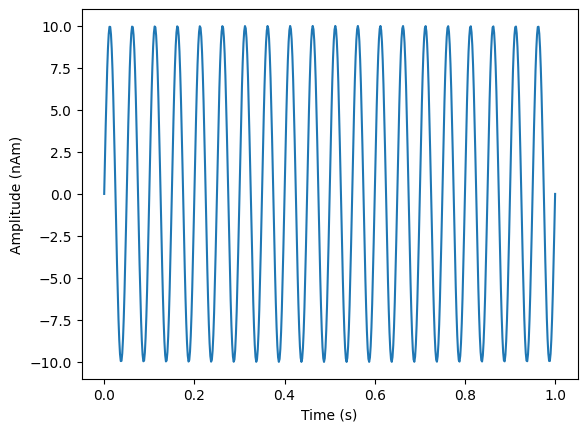

In [19]:
# Frequency of simulated sinusoid (Hz)
freq = 20
# Strength of simulated activity (nAm)
dipole_moment = 10

# Generate 1s of a sine wave at a sampling rate of 600Hz (to match the data file)
time = np.linspace(0,1,s_rate)
sim_signal = np.sin(time*freq*2*np.pi).reshape(1,-1)

plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at

In [20]:
sim_vertex=10561

cam_view = [40, -240, 25,
            60, 37, 17,
            0, 0, 1]
plot = show_surface(
    surf_set,
    marker_vertices=sim_vertex,
    marker_size=5,
    camera_view=cam_view
)

Output()

In [21]:
plot.fetch_screenshot()

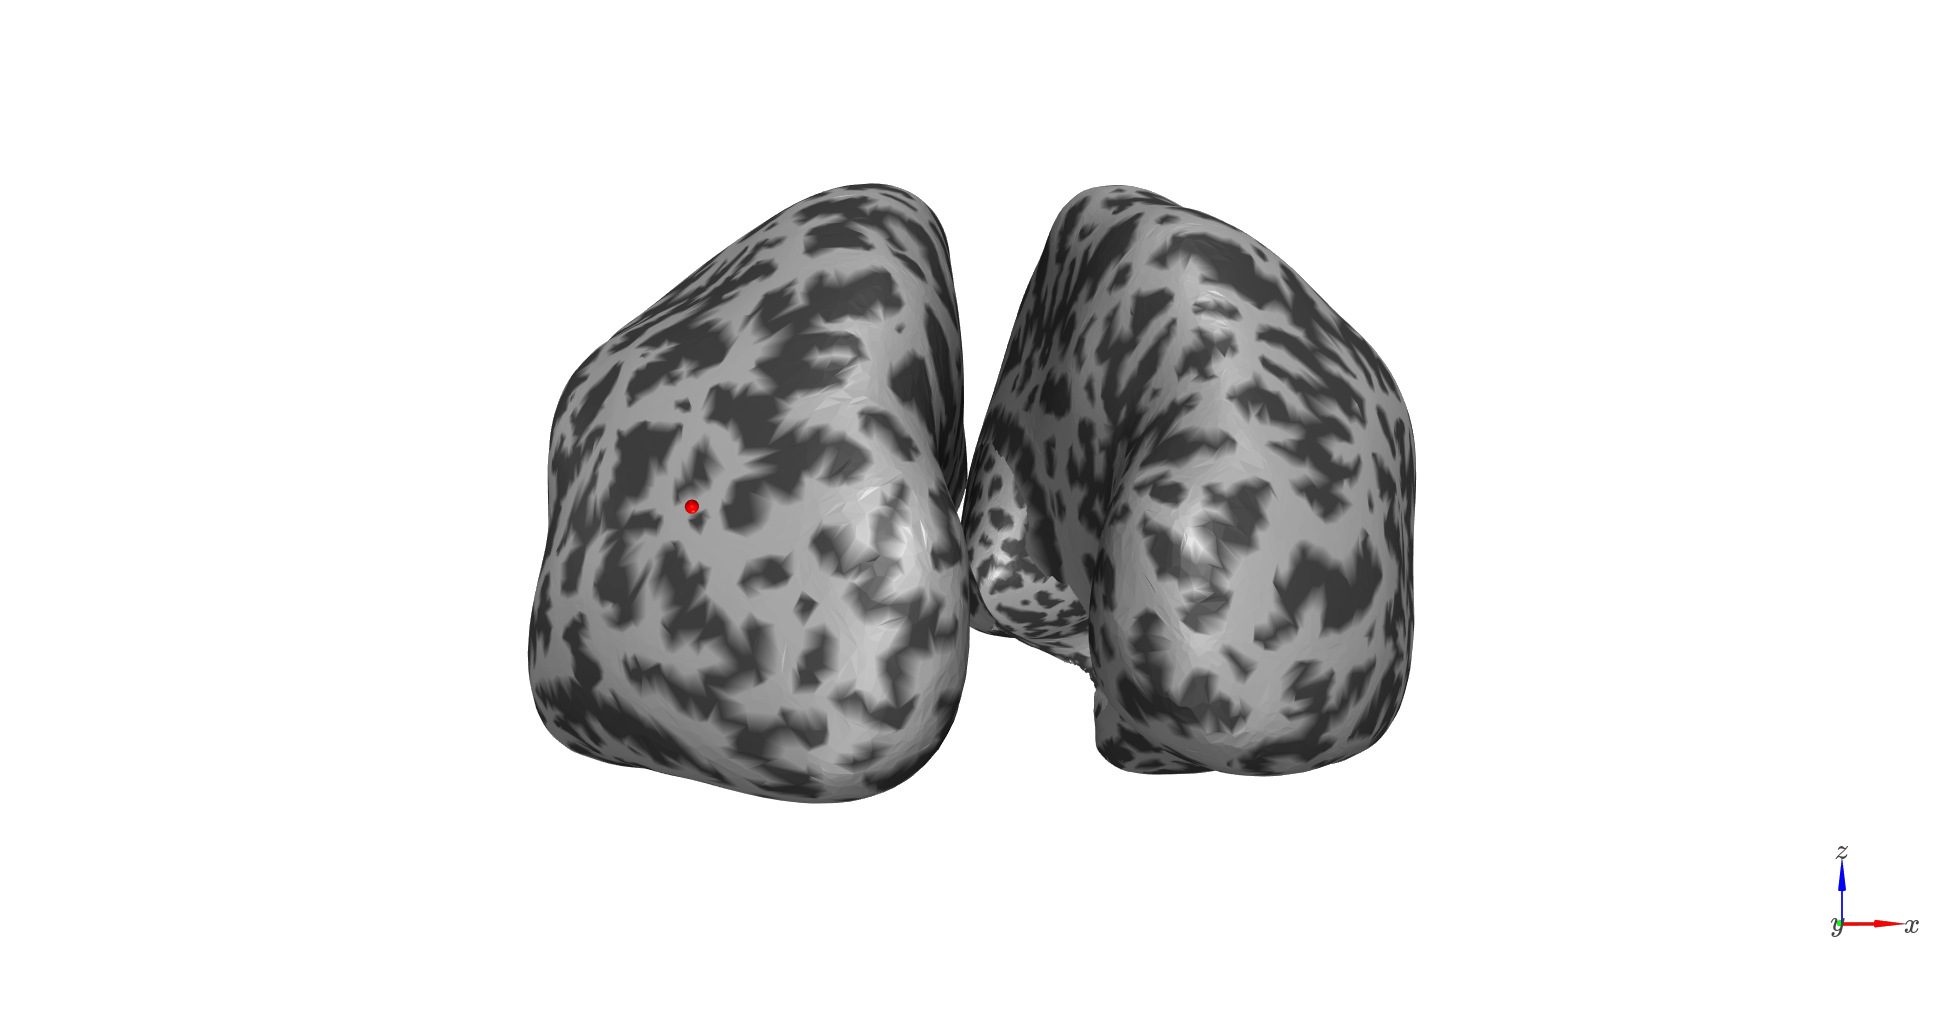

In [22]:
Image(data=base64.b64decode(plot.screenshot))

We'll simulate a 5mm patch of activity with -5 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [10]:
# Simulate at a vertex on the pial surface
pial_vertex = surf_set.get_multilayer_vertex('pial', sim_vertex)
prefix = f'sim_{sim_vertex}_pial_'

# Size of simulated patch of activity (mm)
sim_patch_size = 5
# SNR of simulated data (dB)
SNR = -5

# Generate simulated data
pial_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    pial_vertex, 
    sim_signal, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
)   

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /home/bonaiuto/tmp/tmp8j02y6v_/simprior_sim_10561_pial_test_opm
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 519.45 pAm/mm2, peak momemnt density 1104.22 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 519.45, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1104.22, sd 0.00 pAm/mm2
Saving /home/bonaiuto/tmp/tmp8j02y6v_/simprior_sim_10561_pial_test_opm/prior331073.mat
Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end assemble

 Finish


## Model comparison (pial - white matter)
Now we can run model comparison between source models based on the pial and white matter surfaces using free energy. Specifically, we'll look at the difference in free energy between the two models (pial - white matter). This should be positive (more model evidence for the pial surface model) because we simulated activity on the pial surface

In [11]:
# Run model comparison between the first layer (pial) and the last layer (white matter)
[F,_] = model_comparison(
    fid_coords, 
    pial_sim_fname, 
    surf_set_bilam,
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': n_temp_modes,
        'n_spatial_modes': 60
    }
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 20:31:50 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 20:31:50 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           20:31:55 - 05/11/2025
pial.ds.link_vector.fixed
creating layout from cfg.grad
creating layout for meg system

SPM: spm_eeg_inv_forward                           20:32:41 - 05/11/2025
Completed              

model evidences relative to maximum:

ans =

     0

       priors: []
         type: 'EBB'
          woi: [0 998]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 60
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: -3.0433e+05
      PostMax: [51091x1 double]
            A: [60x216 double]
           Ip: [1x512 double]
            M: [51091x60 double]
            J: {[51091x4 double]}
            L: [60x51091 double]
           qC: [51091x1 double]
        tempU: [511x511 double]
            V: [511x4 double]
           qV: [599x599 double]
            T: [599x4 double]
            U: {[60x216 double]}
           Is: [1x51091 double]
           It: [1x599 double]
           Ik: [1x200 double]
           Ic: {[1x216 double]}
           Nd: 51091
          pst: [1x599 double]
          dct: [1x511 double]
           ID: 233.6117
            F: -3.0433e+05
           R2: 98.8990
           VE: 84.0895

05-Nov-2025

In [12]:
# The difference in free energy is an approximation of the Bayes factor between the two models
# This value should be positive (more model evidence for the pial layer model)
F[0]-F[1]

74971.71919208084

## White matter surface simulation with pial - white matter model comparison
Let's simulate the same pattern of activity, in the same location, but on the white matter surface. This time, model comparison should yield greater model evidence for the white matter surface, and therefore the difference in free energy (pial - white matter) should be negative.

In [13]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex = surf_set.get_multilayer_vertex('white', sim_vertex)
prefix = f'sim_{sim_vertex}_white_'

# Generate simulated data
white_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    white_vertex, 
    sim_signal, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
) 
# Run model comparison between the first layer (pial) and the last layer (white matter)
[F,_] = model_comparison(
    fid_coords, 
    white_sim_fname, 
    surf_set_bilam,
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': n_temp_modes,
        'n_spatial_modes': 60
    }
)

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /home/bonaiuto/tmp/tmp8j02y6v_/simprior_sim_10561_white_test_opm
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 509.88 pAm/mm2, peak momemnt density 1200.53 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 509.88, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1200.53, sd 0.00 pAm/mm2
Saving /home/bonaiuto/tmp/tmp8j02y6v_/simprior_sim_10561_white_test_opm/prior616366.mat
Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                               


SPM: spm_eeg_inv_mesh_ui                           20:39:53 - 05/11/2025
white.ds.link_vector.fixed
creating layout from cfg.grad
creating layout for meg system

SPM: spm_eeg_inv_forward                           20:40:34 - 05/11/2025
Completed                               :          20:40:35 - 05/11/2025
computing surface normals
05-Nov-2025 20:40:36 - Done    'Head model specification'
05-Nov-2025 20:40:36 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/white.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      20:40:37 - 05/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing m

model evidences relative to maximum:

ans =

     0

       priors: []
         type: 'EBB'
          woi: [0 998]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 60
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: -2.9129e+05
      PostMax: [51091x1 double]
            A: [60x216 double]
           Ip: [1x512 double]
            M: [51091x60 double]
            J: {[51091x4 double]}
            L: [60x51091 double]
           qC: [51091x1 double]
        tempU: [511x511 double]
            V: [511x4 double]
           qV: [599x599 double]
            T: [599x4 double]
            U: {[60x216 double]}
           Is: [1x51091 double]
           It: [1x599 double]
           Ik: [1x200 double]
           Ic: {[1x216 double]}
           Nd: 51091
          pst: [1x599 double]
          dct: [1x511 double]
           ID: 156.7485
            F: -2.9129e+05
           R2: 99.9919
           VE: 83.5056

05-Nov-2025

In [14]:
# The difference in free energy is an approximation of the Bayes factor between the two models
# This value should be negative (more model evidence for the white matter layer model)
F[0]-F[1]

-51151.29874526727

## Simulation in each layer with model comparison across layers
That was model comparison with two candidate models: one based on the white matter surface, and one on the pial. Let's now simulate on each layer, and for each simulation, run model comparison across all layers. We'll turn off SPM visualization here.

In [15]:
# Now simulate at the corresponding vertex on each layer, and for each simulation, run model comparison across
# all layers
all_layerF = []

for l in range(surf_set.n_layers):
    print(f'Simulating in layer {l}')
    l_vertex = surf_set.get_multilayer_vertex(l, sim_vertex)
    prefix = f'sim_{sim_vertex}_{l}_'

    l_sim_fname = run_current_density_simulation(
        base_fname, 
        prefix, 
        l_vertex, 
        sim_signal, 
        dipole_moment, 
        sim_patch_size, 
        SNR,
        spm_instance=spm
    ) 

    [layerF,_] = model_comparison(
        fid_coords, 
        l_sim_fname, 
        surf_set,
        viz=False,
        spm_instance=spm,
        invert_kwargs={
            'patch_size': patch_size, 
            'n_temp_modes': n_temp_modes,
            'n_spatial_modes': 60
        }
    )
    all_layerF.append(layerF)
all_layerF = np.array(all_layerF)

Simulating in layer 0
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /home/bonaiuto/tmp/tmp8j02y6v_/simprior_sim_10561_0_test_opm
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 519.45 pAm/mm2, peak momemnt density 1104.22 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 519.45, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1104.22, sd 0.00 pAm/mm2
Saving /home/bonaiuto/tmp/tmp8j02y6v_/simprior_sim_10561_0_test_opm/prior616366.mat
Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                 

model evidences relative to maximum:

ans =

     0

05-Nov-2025 20:45:56 - Done    'Source inversion, iterative'
05-Nov-2025 20:45:56 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 20:45:57 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 20:45:57 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:46:38 - 05/11/2025
Completed     


gainname =

    'SPMgainmatrix_sim_10561_0_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.03 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.053445e+04 [+4.12]
  ReML Iteration 2                      :        ...1.863110e+04 [+4.25]
  ReML Iteration 3                      :        ...1.604820e+04 [+4.38]
  ReML Iteration 4                      :        ...9.523206e+03 [+4.50]
  ReML Iteration 5                      

computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_0_test_opm_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 20:51:41 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 20:51:41 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial

Completed                               :          20:54:28 - 05/11/2025
05-Nov-2025 20:54:29 - Done    'Head model specification'
05-Nov-2025 20:54:29 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      20:54:30 - 05/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_0_test_opm_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __               



------------------------------------------------------------------------
05-Nov-2025 20:56:38 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 20:56:38 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:57:21 - 05/11/2025
Completed                               :          20:57:22 - 05/11/2025
05-Nov-2025 20:57:23 - Done    'Head model specification'
05-Nov-2025 20:57:23 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.200.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      20:57:23 - 05/11/2025
        --------------------

05-Nov-2025 20:59:42 - Done    'Source inversion, iterative'
05-Nov-2025 20:59:42 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 20:59:43 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 20:59:43 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:00:27 - 05/11/2025
Completed                               :          21:00:28 - 05/11

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_10561_1_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.83 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.202374e+04 [+4.12]
  ReML Iteration 2                      :        ...2.068779e+04 [+4.25]
  ReML Iteration 3                      :        ...1.881036e+04 [+4.38]
  ReML Iteration 4                  

05-Nov-2025 21:07:40 - Done    'Source inversion, iterative'
05-Nov-2025 21:07:40 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 21:07:42 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 21:07:42 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:08:27 - 05/11/2025
Completed                               :          21:08:28 - 05/11

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_10561_1_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.80 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.055910e+04 [+4.12]
  ReML Iteration 2                      :        ...1.865105e+04 [+4.25]
  ReML Iteration 3                      :        ...1.605487e+04 [+4.38]
  ReML Iteration 4                 

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      21:13:04 - 05/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_1_test_opm_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


----------------------------------------------------------------

0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:15:58 - 05/11/2025
Completed                               :          21:15:59 - 05/11/2025
05-Nov-2025 21:15:59 - Done    'Head model specification'
05-Nov-2025 21:15:59 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.300.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      21:16:00 - 05/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_1_test_opm_testmodes.mat
SPM, versi

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 21:18:14 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 21:18:14 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:18:54 - 05/11/2025
Completed                               :          21:18:55 - 05/11/2025
05-Nov-2025 21:18:56 - Done    'Head model specification'
05-Nov-2025 21:18:56 - Don

05-Nov-2025 21:21:33 - Done    'Source inversion, iterative'
05-Nov-2025 21:21:33 - Done

Simulating in layer 2
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /home/bonaiuto/tmp/tmp8j02y6v_/simprior_sim_10561_2_test_opm
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 524.55 pAm/mm2, peak momemnt density 1120.10 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 524.55, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1120.10, sd 0.00 pAm/mm2
Saving /home

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 21:27:19 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 21:27:20 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_10561_2_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed

model evidences relative to maximum:

ans =

     0

05-Nov-2025 21:29:13 - Done    'Source inversion, iterative'
05-Nov-2025 21:29:13 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 21:29:15 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 21:29:15 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:30:08 - 05/11/2025
Completed     


gainname =

    'SPMgainmatrix_sim_10561_2_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.60 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.049947e+04 [+4.12]
  ReML Iteration 2                      :        ...1.856471e+04 [+4.25]
  ReML Iteration 3                      :        ...1.593030e+04 [+4.38]
  ReML Iteration 4                      :        ...9.292206e+03 [+4.50]
  ReML Iteration 5                      

computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_2_test_opm_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 21:35:17 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 21:35:17 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial


SPM: spm_eeg_inv_forward                           21:37:52 - 05/11/2025
Completed                               :          21:37:53 - 05/11/2025
05-Nov-2025 21:37:53 - Done    'Head model specification'
05-Nov-2025 21:37:53 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.200.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      21:37:54 - 05/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_2_test_opm_testmodes.mat
SPM, version dev (standalone)
MATLAB,

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 21:40:15 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 21:40:15 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:40:53 - 05/11/2025
Completed                               :          21:40:54 - 05/11/2025
05-Nov-2025 21:40:54 - Done    'Head model specification'
05-Nov-2025 21:40:54 - Don

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_10561_3_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.48 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.065517e+04 [+4.12]
  ReML Iteration 2                      :        ...1.895466e+04 [+4.25]
  ReML Iteration 3                      :        ...1.659481e+04 [+4.38]
  ReML Iteration 4                  

05-Nov-2025 21:48:56 - Done    'Head model specification'
05-Nov-2025 21:48:56 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.800.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      21:48:57 - 05/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_3_test_opm_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                        

05-Nov-2025 21:51:13 - Done    'Source inversion, iterative'
05-Nov-2025 21:51:13 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 21:51:14 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 21:51:14 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:51:54 - 05/11/2025
Completed                               :          21:51:55 - 05/11

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_10561_3_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.44 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.080950e+04 [+4.12]
  ReML Iteration 2                      :        ...1.894767e+04 [+4.25]
  ReML Iteration 3                      :        ...1.640675e+04 [+4.38]
  ReML Iteration 4                 

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      21:56:42 - 05/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_3_test_opm_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


----------------------------------------------------------------



------------------------------------------------------------------------
05-Nov-2025 21:59:03 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 21:59:03 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:59:42 - 05/11/2025
Completed                               :          21:59:43 - 05/11/2025
05-Nov-2025 21:59:44 - Done    'Head model specification'
05-Nov-2025 21:59:44 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      21:59:45 - 05/11/2025
        --------------------

model evidences relative to maximum:

ans =

     0

05-Nov-2025 22:02:17 - Done    'Source inversion, iterative'
05-Nov-2025 22:02:17 - Done

Simulating in layer 4
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /home/bonaiuto/tmp/tmp8j02y6v_/simprior_sim_10561_4_test_opm
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 510.60 pAm/mm2, peak momemnt density 1170.44 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 510.60, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex)



------------------------------------------------------------------------
05-Nov-2025 22:08:08 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 22:08:08 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_10561_4_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.30 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML 

0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:11:09 - 05/11/2025
Completed                               :          22:11:10 - 05/11/2025
05-Nov-2025 22:11:11 - Done    'Head model specification'
05-Nov-2025 22:11:11 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.700.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      22:11:12 - 05/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_4_test_opm_testmodes.mat
SPM, versi

  ReML Iteration 1                      :        ...2.299830e+04 [+4.12]
  ReML Iteration 2                      :        ...2.221005e+04 [+4.25]
  ReML Iteration 3                      :        ...2.095509e+04 [+4.38]
  ReML Iteration 4                      :        ...1.888027e+04 [+4.50]
  ReML Iteration 5                      :        ...1.067312e+04 [+4.62]
  ReML Iteration 6                      :        ...3.809441e+02 [+4.75]
  ReML Iteration 7                      :        ...2.656126e+02 [+4.88]
  ReML Iteration 8                      :        ...2.497490e+02 [+5.00]
  ReML Iteration 9                      :        ...1.831020e+02 [+5.12]
  ReML Iteration 10                     :        ...1.702447e+02 [+5.25]
  ReML Iteration 11                     :        ...1.290914e+02 [+5.38]
  ReML Iteration 12                     :        ...1.188432e+02 [+5.50]
  ReML Iteration 13                     :        ...9.233137e+01 [+5.62]
  ReML Iteration 14                     :        ..

  ReML Iteration 1                      :        ...2.187992e+04 [+4.12]
  ReML Iteration 2                      :        ...2.043265e+04 [+4.25]
  ReML Iteration 3                      :        ...1.841438e+04 [+4.38]
  ReML Iteration 4                      :        ...1.568265e+04 [+4.50]
  ReML Iteration 5                      :        ...8.484459e+03 [+4.62]
  ReML Iteration 6                      :        ...5.326043e+02 [+4.75]
  ReML Iteration 7                      :        ...5.557851e+01 [+4.88]
  ReML Iteration 8                      :        ...1.209618e+01 [+5.00]
  ReML Iteration 9                      :        ...2.154068e+00 [+5.12]
  ReML Iteration 10                     :        ...4.227935e-01 [+5.25]
  ReML Iteration 11                     :        ...7.971158e-02 [+5.38]
  ReML Iteration 12                     :        ...1.530100e-02 [+5.50]
  ReML Iteration 13                     :        ...2.914349e-03 [+5.62]
Inverting subject 1
  ReML Iteration 1             

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      22:17:30 - 05/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_4_test_opm_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


----------------------------------------------------------------



------------------------------------------------------------------------
05-Nov-2025 22:19:42 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 22:19:42 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:20:18 - 05/11/2025
Completed                               :          22:20:19 - 05/11/2025
05-Nov-2025 22:20:19 - Done    'Head model specification'
05-Nov-2025 22:20:19 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      22:20:20 - 05/11/2025
        --------------------

05-Nov-2025 22:22:43 - Done    'Source inversion, iterative'
05-Nov-2025 22:22:43 - Done

Simulating in layer 5
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /home/bonaiuto/tmp/tmp8j02y6v_/simprior_sim_10561_5_test_opm
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 513.40 pAm/mm2, peak momemnt density 1150.74 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 513.40, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1150.74, sd 0.00 pAm/mm2
Saving /home

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_10561_5_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.14 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.005529e+04 [+4.12]
  ReML Iteration 2                      :        ...1.821485e+04 [+4.25]
  ReML Iteration 3                      :        ...1.566669e+04 [+4.38]
  ReML Iteration 4                 

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      22:31:08 - 05/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_5_test_opm_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


----------------------------------------------------------------

05-Nov-2025 22:33:21 - Done    'Source inversion, iterative'
05-Nov-2025 22:33:21 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 22:33:22 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 22:33:22 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:34:02 - 05/11/2025
Completed                               :          22:34:03 - 05/11

05-Nov-2025 22:34:53 - Done    'Source inversion, iterative'
05-Nov-2025 22:34:53 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 22:34:54 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 22:34:54 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:35:42 - 05/11/2025
Completed                               :          22:35:43 - 05/11

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_10561_5_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.11 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.097302e+04 [+4.12]
  ReML Iteration 2                      :        ...1.914896e+04 [+4.25]
  ReML Iteration 3                      :        ...1.664089e+04 [+4.38]
  ReML Iteration 4                 

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      22:40:30 - 05/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_5_test_opm_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


----------------------------------------------------------------

 - done
Saving prior in directory /home/bonaiuto/tmp/tmp8j02y6v_/simprior_sim_10561_6_test_opm
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 514.33 pAm/mm2, peak momemnt density 1215.87 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 514.33, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1215.87, sd 0.00 pAm/mm2
Saving /home/bonaiuto/tmp/tmp8j02y6v_/simprior_sim_10561_6_test_opm/prior616366.mat
Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modifie

Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.02 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.966053e+04 [+4.12]
  ReML Iteration 2                      :        ...1.772147e+04 [+4.25]
  ReML Iteration 3                      :        ...1.504825e+04 [+4.38]
  ReML Iteration 4                      :        ...8.741578e+03 [+4.50]
  ReML Iteration 5                      :        ...1.331433e+03 [+4.62]
  ReML Iteration 6                      :        ...2.684204e-02 [+4.75]
  ReML Iteration 7                      :        ...8.253437e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.966053e+04 [+4.12]
  ReML Iteration 2                      :        ...1.772147e+04 [+4.25]
  ReML Iteration 3                      :        ...1.504825e+04 [+4.38]
  ReML Iteration 4                      

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 22:51:45 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 22:51:45 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_10561_6_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed



------------------------------------------------------------------------
05-Nov-2025 22:53:51 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 22:53:51 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:54:46 - 05/11/2025
Completed                               :          22:54:47 - 05/11/2025
05-Nov-2025 22:54:48 - Done    'Head model specification'
05-Nov-2025 22:54:48 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      22:54:49 - 05/11/2025
        --------------------

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.207081e+04 [+4.12]
  ReML Iteration 2                      :        ...2.068858e+04 [+4.25]
  ReML Iteration 3                      :        ...1.874366e+04 [+4.38]
  ReML Iteration 4                      :        ...1.604060e+04 [+4.50]
  ReML Iteration 5                      :        ...8.635377e+03 [+4.62]
  ReML Iteration 6          



------------------------------------------------------------------------
05-Nov-2025 23:00:39 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 23:00:39 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:01:23 - 05/11/2025
Completed                               :          23:01:24 - 05/11/2025
05-Nov-2025 23:01:25 - Done    'Head model specification'
05-Nov-2025 23:01:25 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      23:01:25 - 05/11/2025
        --------------------

model evidences relative to maximum:

ans =

     0

05-Nov-2025 23:03:31 - Done    'Source inversion, iterative'
05-Nov-2025 23:03:31 - Done

Simulating in layer 7
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /home/bonaiuto/tmp/tmp8j02y6v_/simprior_sim_10561_7_test_opm
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 513.06 pAm/mm2, peak momemnt density 1220.83 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 513.06, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex)



------------------------------------------------------------------------
05-Nov-2025 23:09:33 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 23:09:34 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_10561_7_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML 

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      23:12:29 - 05/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_7_test_opm_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


----------------------------------------------------------------

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 23:14:48 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 23:14:48 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:15:44 - 05/11/2025
Completed                               :          23:15:45 - 05/11/2025
05-Nov-2025 23:15:45 - Done    'Head model specification'
05-Nov-2025 23:15:45 - Don

Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.87 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.231968e+04 [+4.12]
  ReML Iteration 2                      :        ...2.108535e+04 [+4.25]
  ReML Iteration 3                      :        ...1.933498e+04 [+4.38]
  ReML Iteration 4                      :        ...1.682393e+04 [+4.50]
  ReML Iteration 5                      :        ...9.357816e+03 [+4.62]
  ReML Iteration 6                      :        ...5.249990e+02 [+4.75]
  ReML Iteration 7                      :        ...1.071024

05-Nov-2025 23:19:55 - Done    'Source inversion, iterative'
05-Nov-2025 23:19:55 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 23:19:56 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 23:19:56 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:20:34 - 05/11/2025
Completed                               :          23:20:35 - 05/11

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_10561_7_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.86 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.123323e+04 [+4.12]
  ReML Iteration 2                      :        ...1.948053e+04 [+4.25]
  ReML Iteration 3                      :        ...1.706016e+04 [+4.38]
  ReML Iteration 4                 

Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 23:27:28 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 23:27:28 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:28:29 - 05/11/2025
Completed                               :          23:

05-Nov-2025 23:30:56 - Done    'Source inversion, iterative'
05-Nov-2025 23:30:56 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 23:31:00 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 23:31:00 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:31:39 - 05/11/2025
Completed                               :          23:31:40 - 05/11

model evidences relative to maximum:

ans =

     0

05-Nov-2025 23:33:59 - Done    'Source inversion, iterative'
05-Nov-2025 23:33:59 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 23:34:01 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 23:34:01 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:34:40 - 05/11/2025
Completed     

Using 4 temporal modes, accounting for 83.74 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.096174e+04 [+4.12]
  ReML Iteration 2                      :        ...1.930554e+04 [+4.25]
  ReML Iteration 3                      :        ...1.702384e+04 [+4.38]
  ReML Iteration 4                      :        ...1.063985e+04 [+4.50]
  ReML Iteration 5                      :        ...1.937795e+03 [+4.62]
  ReML Iteration 6                      :        ...9.604774e+00 [+4.75]
  ReML Iteration 7                      :        ...9.548242e-01 [+4.88]
  ReML Iteration 8                      :        ...8.526492e-02 [+5.00]
  ReML Iteration 9                      :        ...7.882137e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...2.096174e+04 [+4.12]
  ReML Iteration 2                      :        ...1.930554e+04 [+4.25]
  ReML Iteration 3                      : 

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      23:39:38 - 05/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_8_test_opm_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


----------------------------------------------------------------

05-Nov-2025 23:41:53 - Done    'Source inversion, iterative'
05-Nov-2025 23:41:53 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 23:41:54 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 23:41:54 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:42:33 - 05/11/2025
Completed                               :          23:42:34 - 05/11

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_10561_8_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.73 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.131088e+04 [+4.12]
  ReML Iteration 2                      :        ...1.958138e+04 [+4.25]
  ReML Iteration 3                      :        ...1.718478e+04 [+4.38]
  ReML Iteration 4                 

05-Nov-2025 23:49:39 - Done    'Source inversion, iterative'
05-Nov-2025 23:49:39 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 23:49:45 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 23:49:45 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:50:30 - 05/11/2025
Completed                               :          23:50:31 - 05/11

model evidences relative to maximum:

ans =

     0

05-Nov-2025 23:52:48 - Done    'Source inversion, iterative'
05-Nov-2025 23:52:48 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 23:52:50 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 23:52:50 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:53:42 - 05/11/2025
Completed     

05-Nov-2025 23:56:06 - Done    'Source inversion, iterative'
05-Nov-2025 23:56:06 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
05-Nov-2025 23:56:10 - Running job #1
------------------------------------------------------------------------
05-Nov-2025 23:56:10 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:56:49 - 05/11/2025
Completed                               :          23:56:50 - 05/11

Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.64 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.104341e+04 [+4.12]
  ReML Iteration 2                      :        ...1.940103e+04 [+4.25]
  ReML Iteration 3                      :        ...1.714031e+04 [+4.38]
  ReML Iteration 4                      :        ...1.072333e+04 [+4.50]
  ReML Iteration 5                      :        ...1.949173e+03 [+4.62]
  ReML Iteration 6                      :        ...1.245343e+01 [+4.75]
  ReML Iteration 7                      :        ...1.348403e+00 [+4.88]
  ReML Iteration 8                      :        ...1.296500e-01 [+5.00]
  ReML Iteration 9                      :        ...1.297556e-02 [+5.12]
  ReML Iteration 10                     :        ...1.282716e-03 [+5.25]
Inverting subject 1
  ReML Iteration 1                      

06-Nov-2025 00:01:43 - Done    'Head model specification'
06-Nov-2025 00:01:43 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.200.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      00:01:44 - 06/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_9_test_opm_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                        

  ReML Iteration 1                      :        ...2.297706e+04 [+4.12]
  ReML Iteration 2                      :        ...2.216139e+04 [+4.25]
  ReML Iteration 3                      :        ...2.087397e+04 [+4.38]
  ReML Iteration 4                      :        ...1.875234e+04 [+4.50]
  ReML Iteration 5                      :        ...1.024971e+04 [+4.62]
  ReML Iteration 6                      :        ...2.949067e+02 [+4.75]
  ReML Iteration 7                      :        ...1.991967e+02 [+4.88]
  ReML Iteration 8                      :        ...1.764879e+02 [+5.00]
  ReML Iteration 9                      :        ...1.254218e+02 [+5.12]
  ReML Iteration 10                     :        ...1.095556e+02 [+5.25]
  ReML Iteration 11                     :        ...8.048384e+01 [+5.38]
  ReML Iteration 12                     :        ...6.945539e+01 [+5.50]
  ReML Iteration 13                     :        ...5.222438e+01 [+5.62]
  ReML Iteration 14                     :        ..

model evidences relative to maximum:

ans =

     0

06-Nov-2025 00:05:28 - Done    'Source inversion, iterative'
06-Nov-2025 00:05:28 - Done

Simulating in layer 10
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /home/bonaiuto/tmp/tmp8j02y6v_/simprior_sim_10561_10_test_opm
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 509.88 pAm/mm2, peak momemnt density 1200.53 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 509.88, sd 0.00 pAm/mm2
Prior 1. Average Peak (max verte



------------------------------------------------------------------------
06-Nov-2025 00:11:28 - Running job #1
------------------------------------------------------------------------
06-Nov-2025 00:11:28 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_10561_10_test_opm_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.2118    0.6940
    0.2968    0.1321

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.54 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      00:14:34 - 06/11/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 216 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmp8j02y6v_/sim_10561_10_test_opm_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


---------------------------------------------------------------



------------------------------------------------------------------------
06-Nov-2025 00:16:58 - Running job #1
------------------------------------------------------------------------
06-Nov-2025 00:16:58 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:17:41 - 06/11/2025
Completed                               :          00:17:42 - 06/11/2025
06-Nov-2025 00:17:42 - Done    'Head model specification'
06-Nov-2025 00:17:42 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      00:17:43 - 06/11/2025
        --------------------

06-Nov-2025 00:20:00 - Done    'Source inversion, iterative'
06-Nov-2025 00:20:00 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
06-Nov-2025 00:20:02 - Running job #1
------------------------------------------------------------------------
06-Nov-2025 00:20:02 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:20:49 - 06/11/2025
Completed                               :          00:20:50 - 06/11

Using 60 spatial modesNumber of samples 599
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.52 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.171280e+04 [+4.12]
  ReML Iteration 2                      :        ...2.023994e+04 [+4.25]
  ReML Iteration 3                      :        ...1.820519e+04 [+4.38]
  ReML Iteration 4                      :        ...1.547393e+04 [+4.50]
  ReML Iteration 5                      :        ...8.265824e+03 [+4.62]
  ReML Iteration 6                      :        ...4.935031e+02 [+4.75]
  ReML Iteration 7                      :        ...4.836053e+01 [+4.88]
  ReML Iteration 8                      :        ...9.722058e+00 [+5.00]
  ReML Iteration 9                      :        ...1.615421e+00 [+5.12]
  ReML Iteration 10                     :        ...2.933205e-01 [+5.25]
  ReML Iteration 11                     :        ...5.140261



------------------------------------------------------------------------
06-Nov-2025 00:24:59 - Running job #1
------------------------------------------------------------------------
06-Nov-2025 00:24:59 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:25:37 - 06/11/2025
Completed                               :          00:25:37 - 06/11/2025
06-Nov-2025 00:25:38 - Done    'Head model specification'
06-Nov-2025 00:25:38 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/white.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using 60 spatial modes

        SPM: spm_eeg_lgainmat                      00:25:38 - 06/11/2025
        --------------------

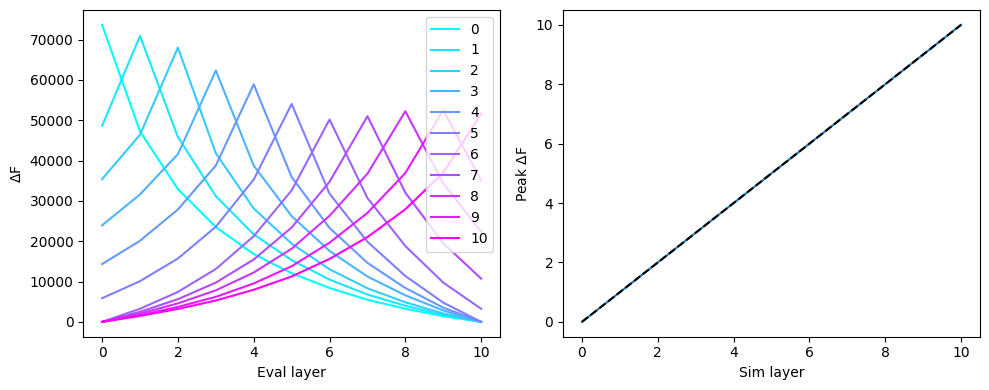

In [24]:
col_r = plt.cm.cool(np.linspace(0,1, num=surf_set.n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the free energy of each layer model relative to that of the worst
# model for that simulation
plt.subplot(1,2,1)
for l in range(surf_set.n_layers):
    layerF = all_layerF[l,:]
    plt.plot(layerF-np.min(layerF), label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel(r'$\Delta$F')

# For each simulation, find which layer model had the greatest free energy
plt.subplot(1,2,2)
peaks = []
for l in range(surf_set.n_layers):
    layerF = all_layerF[l,:]
    pk = np.argmax(layerF)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel(r'Peak $\Delta$F')
plt.tight_layout()

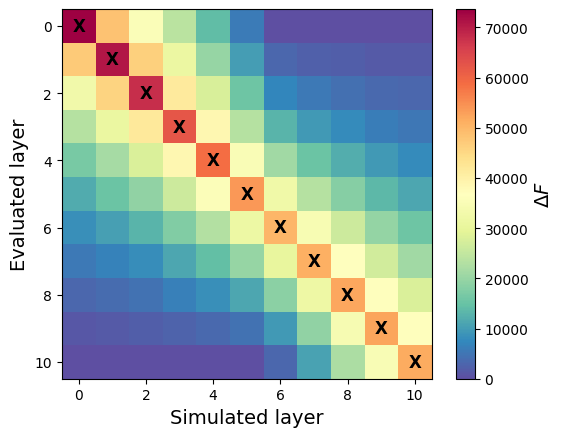

In [25]:
# Normalization step
norm_layerF = np.zeros(all_layerF.shape)
for l in range(surf_set.n_layers):
    norm_layerF[l,:] = all_layerF[l,:] - np.min(all_layerF[l,:])

# Transpose for visualization
im=plt.imshow(norm_layerF.T,cmap='Spectral_r')

# Find the indices of the max value in each column
max_indices = np.argmax(norm_layerF, axis=1)

# Plot an 'X' at the center of the square for each column's maximum
for idx, max_idx in enumerate(max_indices):
    plt.text(idx, max_idx, 'X', fontsize=12, ha='center', va='center', color='black', weight='bold')

plt.xlabel('Simulated layer', fontsize=14)
plt.ylabel('Evaluated layer', fontsize=14)
cb=plt.colorbar(im)
cb.set_label(r'$\Delta F$', fontsize=14)

In [26]:
spm.terminate()

# Delete simulation files
shutil.rmtree(tmp_dir)